Running on device: cuda
Configuration: {'dataset_choice': 'mnist', 'epochs': 30, 'batch_size': 128, 'noise_dim': 100, 'learning_rate': 0.0002, 'save_interval': 5, 'device': 'cuda'}


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.75MB/s]



--- Phase 0: Setting up 'Pre-trained' Classifier ---
Classifier setup complete.

--- Phase 1: Training GAN for 30 epochs ---
Epoch 1/30 | D_loss: 0.0401 | D_acc: 98.96% | G_loss: 7.0879
Epoch 2/30 | D_loss: 0.0104 | D_acc: 100.00% | G_loss: 6.3054
Epoch 3/30 | D_loss: 0.0184 | D_acc: 99.48% | G_loss: 6.3308
Epoch 4/30 | D_loss: 0.0087 | D_acc: 100.00% | G_loss: 5.3174
Epoch 5/30 | D_loss: 0.0073 | D_acc: 99.48% | G_loss: 11.3625
   -> Saved samples to generated_samples/epoch_05.png
Epoch 6/30 | D_loss: 0.0838 | D_acc: 98.96% | G_loss: 6.6229
Epoch 7/30 | D_loss: 0.2230 | D_acc: 95.83% | G_loss: 15.2332
Epoch 8/30 | D_loss: 0.1085 | D_acc: 98.44% | G_loss: 12.9074
Epoch 9/30 | D_loss: 0.0381 | D_acc: 98.96% | G_loss: 4.6421
Epoch 10/30 | D_loss: 0.1854 | D_acc: 90.10% | G_loss: 5.2574
   -> Saved samples to generated_samples/epoch_10.png
Epoch 11/30 | D_loss: 0.1936 | D_acc: 94.27% | G_loss: 3.1515
Epoch 12/30 | D_loss: 0.1080 | D_acc: 98.96% | G_loss: 3.5794
Epoch 13/30 | D_loss: 0.14

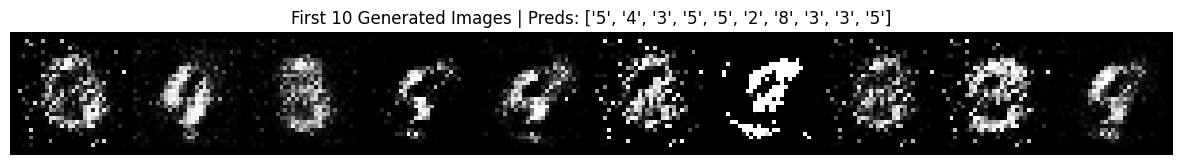

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

config = {
    'dataset_choice': 'mnist',      # Options: 'mnist' or 'fashion'
    'epochs': 30,                   # Recommended: 30-100
    'batch_size': 128,              # Recommended: 64 or 128
    'noise_dim': 100,               # Dimension of random noise vector
    'learning_rate': 0.0002,        # Adam optimizer learning rate
    'save_interval': 5,             # Save samples every k epochs
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Running on device: {config['device']}")
print(f"Configuration: {config}")


os.makedirs('generated_samples', exist_ok=True)
os.makedirs('final_generated_images', exist_ok=True)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

if config['dataset_choice'] == 'mnist':
    dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                       transform=transform, download=True)
elif config['dataset_choice'] == 'fashion':
    dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                              transform=transform, download=True)
else:
    raise ValueError("Invalid dataset_choice. Use 'mnist' or 'fashion'.")

dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)


class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

print("\n--- Phase 0: Setting up 'Pre-trained' Classifier ---")
classifier = SimpleClassifier().to(config['device'])
# We load a quick loop just to ensure it works (in a real scenario, you'd load weights)
cls_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
cls_criterion = nn.CrossEntropyLoss()

# Train classifier for just 1 epoch to save time for the lab
classifier.train()
for batch_idx, (data, target) in enumerate(dataloader):
    data, target = data.to(config['device']), target.to(config['device'])
    cls_optimizer.zero_grad()
    output = classifier(data)
    loss = cls_criterion(output, target)
    loss.backward()
    cls_optimizer.step()
    if batch_idx > 100: break # Stop early, just proving concept
print("Classifier setup complete.\n")

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 28*28),
            nn.Tanh() # Output -1 to 1 to match data normalization
        )

    def forward(self, x):
        img = self.model(x)
        img = img.view(img.size(0), 1, 28, 28) # Reshape to image dimensions [cite: 46]
        return img

# Discriminator: Image (1x28x28) -> Probability (0-1)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # Output probability
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) # Flatten
        validity = self.model(img_flat)
        return validity

# Initialize Models
generator = Generator(config['noise_dim']).to(config['device'])
discriminator = Discriminator().to(config['device'])

# Optimizers and Loss
optimizer_G = optim.Adam(generator.parameters(), lr=config['learning_rate'])
optimizer_D = optim.Adam(discriminator.parameters(), lr=config['learning_rate'])
adversarial_loss = nn.BCELoss() # Binary Cross Entropy


print(f"--- Phase 1: Training GAN for {config['epochs']} epochs ---")

for epoch in range(config['epochs']):
    for i, (imgs, _) in enumerate(dataloader):

        # Ground truths
        real_imgs = imgs.to(config['device'])
        batch_size = real_imgs.size(0)

        # Labels: 1 for real, 0 for fake
        valid = torch.ones(batch_size, 1).to(config['device'])
        fake = torch.zeros(batch_size, 1).to(config['device'])

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise
        z = torch.randn(batch_size, config['noise_dim']).to(config['device'])

        # Generate images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Calculate Discriminator Accuracy for logging
        with torch.no_grad():
            pred_real = discriminator(real_imgs) >= 0.5
            pred_fake = discriminator(gen_imgs.detach()) < 0.5
            d_acc = (pred_real.float().mean() + pred_fake.float().mean()) / 2 * 100

    # Output 1: Training Logs [cite: 51-53]
    print(f"Epoch {epoch+1}/{config['epochs']} | D_loss: {d_loss.item():.4f} | D_acc: {d_acc.item():.2f}% | G_loss: {g_loss.item():.4f}")

    # Output 2: Save Generated Samples Periodically [cite: 54-56]
    if (epoch + 1) % config['save_interval'] == 0:
        save_file = f"generated_samples/epoch_{epoch+1:02d}.png"
        save_image(gen_imgs.data[:25], save_file, nrow=5, normalize=True) # Grid 5x5 [cite: 48]
        print(f"   -> Saved samples to {save_file}")



print("\n--- Phase 2: Final Generation & Evaluation ---")

# A. Generate 100 synthetic images
num_final_samples = 100
z_final = torch.randn(num_final_samples, config['noise_dim']).to(config['device'])
final_imgs = generator(z_final)

# Save them individually as requested
for k in range(num_final_samples):
    save_image(final_imgs[k], f"final_generated_images/img_{k}.png", normalize=True)

print(f"Saved 100 final images to 'final_generated_images/' folder.")

# B. Predict Labels using Pre-trained Classifier
classifier.eval()
with torch.no_grad():
    outputs = classifier(final_imgs)
    _, predicted_labels = torch.max(outputs, 1)

# Map numeric labels to names for better readability
if config['dataset_choice'] == 'fashion':
    label_map = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
                 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
else: # MNIST
    label_map = {i: str(i) for i in range(10)}

predicted_names = [label_map[p.item()] for p in predicted_labels]
label_counts = Counter(predicted_names)

print("\n--- Output 4: Label Distribution of Generated Images ---")
print("How the pre-trained classifier sees our fake images:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# Optional: Visualize a few final samples with their predicted labels
grid_img = make_grid(final_imgs[:10], nrow=10, normalize=True)
plt.figure(figsize=(15, 2))
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.title(f"First 10 Generated Images | Preds: {[predicted_names[i] for i in range(10)]}")
plt.axis('off')
plt.show()